In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from util import *
import model
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


# Inspect first track data
Look at distribution of the data and visualize preprocessing.

In [2]:
data_csv = './data/driving_log.csv'
img_dir = './data/IMG/'

In [3]:
training_data = pd.read_csv(data_csv)
training_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


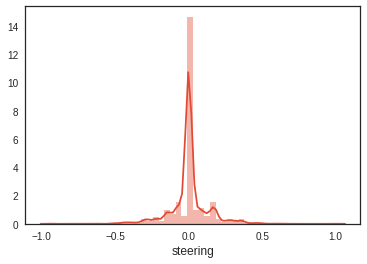

In [4]:
sns.distplot(training_data.steering)

From the distribution plot of steering measurements, we can see that our data is strongly skewed, with over 70 % of data under magnitude of .8.

In [5]:
training_data.steering[lambda x: abs(x) < .08].shape[0]  /training_data.steering.shape[0]

0.7003484320557491

## Next let's see how three camera angles look
If we crop out bottom portion of the image showing front of the car, we will be able to use left and right image as training data. Small off set will be added to steering measurement value for left/right image and will be fed into our network as center image.

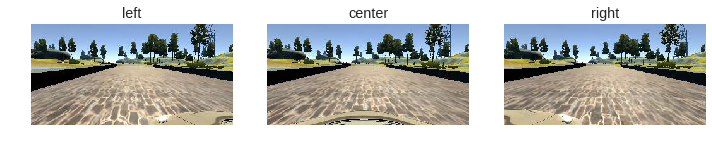

In [6]:
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(1,3,1)
ax.set_title('left')
ax.axis('off')
image = plt.imread(img_dir + training_data.left[0].split('/')[-1])
plt.imshow(image)

ax = fig.add_subplot(1,3,2)
ax.set_title('center')
ax.axis('off')
image = plt.imread(img_dir + training_data.center[0].split('/')[-1])
plt.imshow(image)

ax = fig.add_subplot(1,3,3)
ax.set_title('right')
ax.axis('off')
image = plt.imread(img_dir + training_data.right[0].split('/')[-1])
plt.imshow(image)

plt.tight_layout()

## Preprocessing image
Let's look at each steps of preprocessing.  
1. Convert to YUV  
Original NVIDIA model used YUV channel, and using YUV channel outputted much better result, especially for track 2.
2. Apply random sheer to redistribute data (add curves)
3. Apply random flip to balance right/left turns
4. Crop top, bottom to exclude sky and car.
5. Normalize

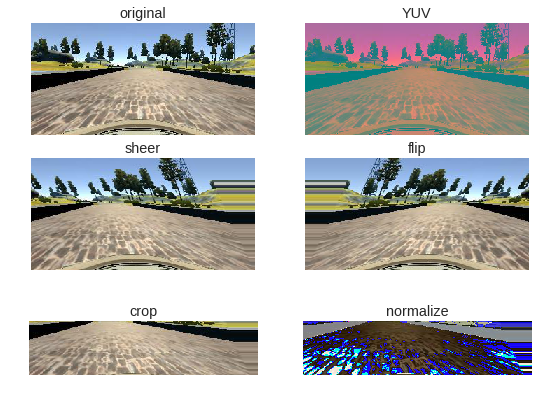

In [7]:
fig = plt.figure(figsize=(9, 7))

ax = plt.subplot2grid((3,2), (0,0))
ax.set_title('original')
ax.axis('off')
image = plt.imread(img_dir + training_data.center[0].split('/')[-1])
ax.imshow(image)

ax = plt.subplot2grid((3, 2), (0,1))
ax.set_title('YUV')
ax.axis('off')
ax.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))

ax = plt.subplot2grid((3,2), (1,0))
ax.set_title('sheer')
ax.axis('off')
image = random_shear(image, steering=1, shear_range=40)[0]
ax.imshow(image)

ax = plt.subplot2grid((3,2), (1,1))
ax.set_title('flip')
ax.axis('off')
ax.imshow(cv2.flip(image, 1))

ax = plt.subplot2grid((3,2), (2,0))
ax.set_title('crop')
ax.axis('off')
image = image[65:-20,...]
ax.imshow(image)

ax = plt.subplot2grid((3,2), (2,1))
ax.set_title('normalize')
ax.axis('off')
ax.imshow(image/255 -.5)

# Inspect second track data
I collected training data for second track by driving around the track for 2 laps.  
The steering measeurements for second track were more evenly distributed compared to the first tack data, so random sheering was removed from preprocessing.

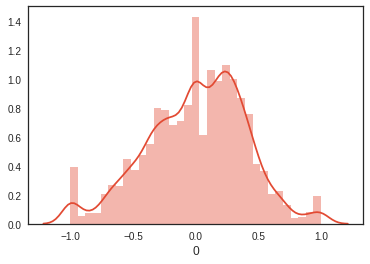

In [8]:
data_csv = './data2/driving_log.csv'
img_dir = './data2/IMG/'
training_data = pd.read_csv(data_csv)
sns.distplot(training_data.iloc[:,3])

In [10]:
print(training_data.shape)

(5330, 7)


## Building model
I used [Nvidia's model](http://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) with slight simplifications.


In [9]:
model.build_model('dummy').summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 160, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 80, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 40, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 40, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 40, 64)        36928     
__________

## Training data
I used provided data set for track 1. I trained the model for 2 epochs.

| Layer (type)            |     Output Shape       |       Param    |
|:------|:----|:----|
| cropping2d_4 (Cropping2D)  |  (None, 80, 320, 3) |       0       |  
| lambda_4 (Lambda)   |         (None, 80, 320, 3)  |      0      |   
| conv2d_16 (Conv2D)     |      (None, 40, 160, 24)  |     1824   |   
| conv2d_17 (Conv2D)        |   (None, 20, 80, 36)    |    21636     |
| conv2d_18 (Conv2D)       |    (None, 10, 40, 48)   |     43248     |
| conv2d_19 (Conv2D)    |      (None, 10, 40, 64)   |     27712     |
| conv2d_20 (Conv2D)       |    (None, 10, 40, 64)  |     36928     |
| flatten_4 (Flatten)     |     (None, 25600)    |         0         |
| dense_13 (Dense)      |       (None, 100)      |        2560100   |
| dense_14 (Dense)       |      (None, 50)       |         5050      |
| dense_15 (Dense)       |      (None, 10)        |        510       |
| dense_16 (Dense)      |       (None, 1)       |          11        |
| | | |
| Total params: 2,697,019.0 | Trainable params: 2,697,019.0  | Non-trainable params: 0.0 |
_________________________________________________________________



# Results
The models separately trained for each track.

| Track 1 | Track2 |
| :----: | :----: |
| [![Track 1](https://img.youtube.com/vi/kmcRsvL4OpE/0.jpg)](http://www.youtube.com/watch?v=kmcRsvL4OpE) | [![Track 2](https://img.youtube.com/vi/fnzufSZ4NU0/0.jpg)](http://www.youtube.com/watch?v=fnzufSZ4NU0)  |